## Build network using pretrained MobileNet_V2 architecture for Self created Drone dataset

## Attempt-1: Feezing all pre-trained layer and adding own classifier


In [1]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch

# check the allocation machine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
cuda avaiable: True, Device: cuda:0


In [3]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session2/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session2


In [4]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [6]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [7]:
#import shutil
#shutil.rmtree('./logs_v2')

In [8]:
from pathlib import Path

# important folders used in this application

SOLUTION_LOG_DIR = "logs_v1_new"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [9]:
from utils.common_utils import LR_UPDATE_TY

# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=128,
    num_workers=6,
    epochs=30,
    lr_update_ty=LR_UPDATE_TY.EPOCHWISE,
    resume_training = False,
    load_model_path = Path(f'./{SAVED_MODELS_DIR}/ep2_testloss_1.160373000.pth'), # used when resume_training is True
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [10]:
# dataset path where zip files are placed
src_dataset_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/s2_dataset/'
#src_dataset_dir = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session2/s2_dataset_v1/'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva4p2_s2_dataset'

In [11]:
import shutil
#shutil.rmtree(root_dataset)

In [12]:
class_list = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
class_list_shortname = ['FB', 'LQC', 'SQC', 'WD']

# Preparing Dataset

In [13]:
# Extracting zipped dataset into colab internal memory
%%time

import zipfile
def extract_dataset(fn, dest):
    with open(fn, 'rb') as f:
      zf = zipfile.ZipFile(f)
      zf.extractall(dest)
      
# create root destination folder
if not Path(root_dataset).exists():
  Path(root_dataset).mkdir(exist_ok=True)

# extract individual class zip file
for classname in class_list:
  class_zipname = f'{src_dataset_dir}/{classname}.zip'  
  class_dir = f'{root_dataset}/{classname}' # class folder unzip location
  if not Path(class_dir).exists():
    print(f'Extracting {classname} images...')
    extract_dataset(fn=class_zipname, dest=class_dir)

Extracting Flying Birds images...
Extracting Large QuadCopters images...
Extracting Small QuadCopters images...
Extracting Winged Drones images...
CPU times: user 27.5 s, sys: 7.01 s, total: 34.5 s
Wall time: 2min 8s


In [15]:
# dataset count-summary
def get_dataset_count(roordir, classlist):
    total = 0
    for classname in classlist:
      classdir = os.path.join(roordir, classname)
      classcnt = len(os.listdir(classdir))
      total += classcnt
      print(f'{classname}: {classcnt} images')

    print(f'\nTotal images: {total}')
    return

def display_classnames(shortname_list, fullname_list):
  for shortname, fullname in zip(shortname_list, fullname_list):
    print(f'{shortname}: {fullname}') 

In [16]:
get_dataset_count(root_dataset, class_list)

Flying Birds: 8338 images
Large QuadCopters: 4169 images
Small QuadCopters: 3623 images
Winged Drones: 5675 images

Total images: 21805


# Remove all duplicate and errornous file

In [17]:
import pandas as pd
df_dataset = pd.read_csv('eda_duplicate_list.csv')
df_remove = df_dataset[(df_dataset['duplicate'] == 1) | (df_dataset['cross_duplicate'] == 1) | (df_dataset['errornous_file'] == 1)]
print(f'File to removes: {len(df_remove)}')
df_remove['classname'].value_counts()

File to removes: 2376


Winged Drones        1486
Flying Birds          407
Small QuadCopters     317
Large QuadCopters     166
Name: classname, dtype: int64

In [18]:
df_remove.head()

,filename,classname,errornous_file,duplicate,parent_img,cross_duplicate,duplicate_class
397,Flying Birds/fb_img_0430.jpg,Flying Birds,0,1,Flying Birds/flying-common-raven-picture-id117...,0,NaN
470,Flying Birds/animal-photography-bird-flying-50...,Flying Birds,0,1,Flying Birds/white-bird-50685.jpg,0,NaN
613,Flying Birds/Copy of 4d34f43aadc32f89c38c37493...,Flying Birds,0,1,Flying Birds/4d34f43aadc32f89c38c37493eed81170...,0,NaN
904,Flying Birds/ZHATuKpukACkWHz5ObmLRgHaEK.jpg,Flying Birds,0,1,Flying Birds/image132.jpg,0,NaN
958,Flying Birds/aFrDNzUEXrI.jpg,Flying Birds,0,1,Flying Birds/photo-1512830488078-82f3fda58d65.jpg,0,NaN


In [19]:
from tqdm import tqdm
def remove_files(rootdir, df_data):
    dvalues = df_data.values
    pbar = tqdm(dvalues)
    for idx, item in enumerate(pbar):
      filename = dvalues[idx][0]
      filepath = f'{rootdir}/{filename}'  
      if Path(filepath).exists():
        os.remove(filepath)
      pbar.set_description(desc=f'Removing files..')
    return

In [20]:
remove_files(root_dataset, df_remove)

Removing files..: 100%|██████████| 2376/2376 [00:02<00:00, 817.45it/s]


In [21]:
# check the final dataset summary used for model building
get_dataset_count(root_dataset, class_list)

Flying Birds: 7931 images
Large QuadCopters: 4003 images
Small QuadCopters: 3306 images
Winged Drones: 4189 images

Total images: 19429


# Prepare Data Transforms and DataLoader

In [22]:
from torchvision import transforms

# Transform functions
def get_train_transform(means, stds):
    train_tf = transforms.Compose([
           transforms.Resize((224,224)),
           transforms.ColorJitter(brightness=0.10, contrast=0.10),
           #transforms.RandomRotation((-7.0, 7.0), fill(1,)),
           #transforms.RandomCrop(32, padding=4),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(means, stds),
           transforms.RandomErasing(scale=(0.02, 0.20), ratio=(0.8, 1.2)),
           #transforms,RandomResizing(scale=(0.02, 0.20), ratio=(0.8, 1.2))                        
    ])
    return train_tf

def get_test_transform(means, stds):
    test_tf = transforms.Compose([
           transforms.Resize((224,224)),
           transforms.ToTensor(),
           transforms.Normalize(means, stds)                
    ])
    return test_tf


In [23]:
means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transforms = get_train_transform(means, stds)
test_transforms = get_test_transform(means, stds)

In [24]:
import utils.data_utils as dutils

dataloader_args = dict(shuffle=False, batch_size=config_params["batch_size"], num_workers=config_params["num_workers"], pin_memory=True) if isCuda else dict(shuffle=True, batch_size=8)

train_loader, test_loader = dutils.prepare_dataloader(datadir=root_dataset, 
                                               train_transforms=train_transforms, 
                                               test_transforms=test_transforms, 
                                               dataloader_args=dataloader_args, 
                                               valid_size=0.30)

print(f'Classes: {train_loader.dataset.classes}')


Total data: 19429

Training size: 13601
Testing size: 5828
Classes: ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# Visualize few training images

In [25]:
from utils.plot_utils import PlotUtils

putils = PlotUtils(device, class_list_shortname, means, stds)

FB: Flying Birds
LQC: Large QuadCopters
SQC: Small QuadCopters
WD: Winged Drones


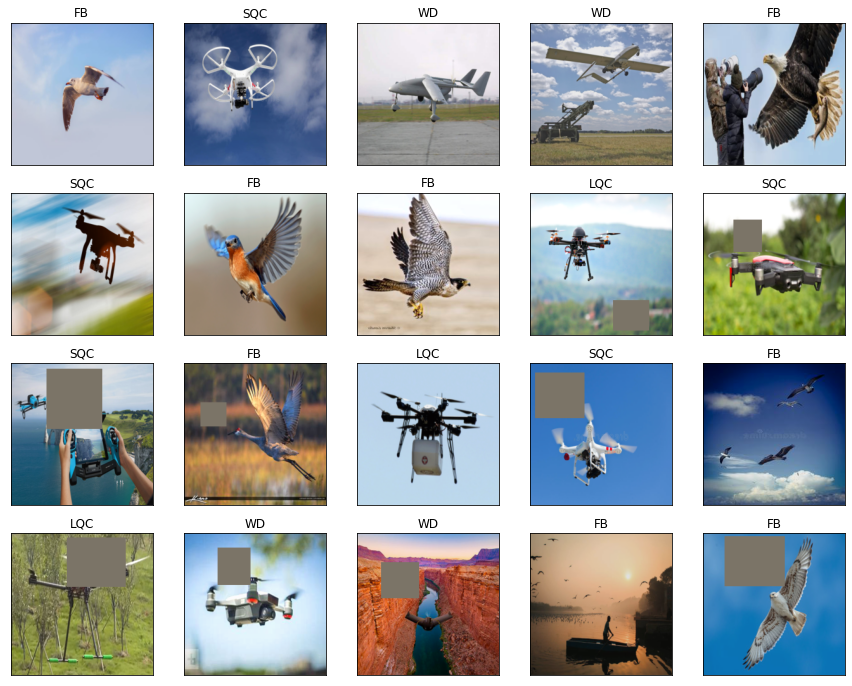

In [25]:
# visualize how image aumentation is applied on few training dataset images: 
display_classnames(class_list_shortname, class_list)
putils.plot_dataset_images(train_loader, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

In [ ]:
%time
samples = next(iter(train_loader))

# Image dimension
print(f'Image size: {samples[0][0].shape}')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Image size: torch.Size([3, 224, 224])


# Pretrained MobileNet_V2 network

In [26]:
from torchvision.models import mobilenet_v2
model = mobilenet_v2(pretrained=True)
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

### Freeze all pre-trained layer and replace the existing classifier layer with own classifier layer. Only own classifiere layer will bre trained and its weight will be learned while training

In [27]:
def freeze_all_layers(model):
    for name, layer in model.named_modules():
        for parameter in layer.parameters():
          parameter.requires_grad = False

def unfreeze_layers_by_name(model, unfreeze_layer_name_list):
    for name, layer in model.named_modules():
      unfreeze = any(n in name for n in unfreeze_layer_name_list)
      if(unfreeze):
        for parameter in layer.parameters():
          parameter.requires_grad = True
      else:
        for parameter in layer.parameters():
          parameter.requires_grad = False

def unfreeze_layers_by_ids(model, unfreeze_layer_ids_list):
    # MobileNet_V2 have 19 features block accessible throunf name: features[idx]
    for idx in range(19):
      if idx in unfreeze_layer_ids_list:
        for param in model.features[idx].parameters():
          param.requires_grad = True
      else:
        for param in model.features[idx].parameters():
          param.requires_grad = False

def show_layers(model):
    for name, layer in model.named_modules():
      for parameter in layer.parameters():
        print(f'Layer name: {name}, Requires Grad: {parameter.requires_grad}')

In [28]:
'''
unfreeze_layer_names = ['features.16', 'features.17', 'features.18', 'classifier']
unfreeze_layers_by_name(model, unfreeze_layer_names)
'''
freeze_all_layers(model)

In [29]:
show_layers(model)

Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requir

In [30]:
#unfreeze_layers_idx = [16, 17, 18]
#unfreeze_selective_layers_by_ids(model, unfreeze_layers_idx )

In [31]:
# adding own FC and classification layer.. these layer will be trained 
model.classifier = nn.Sequential(nn.Dropout(0.2),
                                 nn.Linear(1280, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 1024),
                                 nn.Linear(1024, 4),
                                 nn.LogSoftmax(dim=1))

In [32]:
show_layers(model)

Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requires Grad: False
Layer name: , Requir

In [33]:
from torchsummary import summary
model_name = "MobileNet_V2"
model = model.to(device)
summary(model, input_size=(3,224,224))
#print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

## LR Finder

The model is trained for num_iter iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to end_lr. The increase can be linear (step_mode="linear") or exponential (step_mode="exp"); linear provides good results for small ranges while exponential is recommended for larger ranges

In [33]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


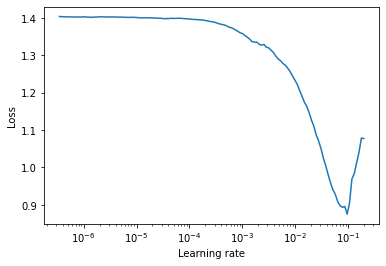

In [34]:
# Note that the loss in the loss vs. learning rate plot is the training loss.
lr_finder.plot()


In [ ]:
# To restore the model and optimizer to their initial state
lr_finder.reset()

'''
Here model is evaluated on that validation dataset after each iteration.
The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run
'''
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=200, step_mode="exp")

In [ ]:
# Note that the loss in the loss vs. learning rate plot is the validation loss.
lr_finder.plot()

## Build and train model

In [34]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
import torch.nn.functional as F

EPOCHS = config_params['epochs']
max_lr = 0.1   # maximum LR 
min_lr = 1e-3   # minimum LR 
L2_val = 1e-4 # L2 Regularization
start_epoch = 1
step_size = 8 # num of epoch, if LR is update epoch wise
if config_params["lr_update_ty"] == LR_UPDATE_TY.BATCHWISE:
  step_size = 2000

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=min_lr, momemtum=0.9, nesterov=True, weight_decay=L2_val) 
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val)  

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size, mode='triangular2', last_epoch=-1)

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)


In [35]:
import utils.model_utils as mutils_fxn

# if resuming the traning then load the model, update optimizer states and loss state
if config_params["resume_training"] == True:
  print("This is resuming the training session...")
  model, optimizer, start_epoch, criterion = mutils_fxn.load_checkpoint(model, optimizer, device, config_params["load_model_path"])
else:
  print("This is fresh attempt training ...")

This is fresh attempt training ...


In [36]:
from utils.model_utils import ModelUtils
mutils = ModelUtils(model, 
                    device, 
                    train_loader=train_loader, 
                    test_loader=test_loader, 
                    start_epoch = start_epoch,
                    epochs=EPOCHS,
                    criterion=criterion, 
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    lr_update_ty=config_params['lr_update_ty'],
                    reduceLr_scheduler=reduceLr_scheduler,
                    saved_model_dir=SAVED_MODELS_DIR)

In [37]:
m_history = mutils.build()

  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 1 TRAIN ==> [Batch=107] train_loss=1.132077 train_acc: 50.19 LR=0.001: 100%|██████████| 107/107 [03:30<00:00,  1.96s/it]
Epoch: 1 TEST  ==> [Batch=46] test_loss=0.827990 test_acc: 73.94: 100%|██████████| 46/46 [01:18<00:00,  1.70s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 2 TRAIN ==> [Batch=107] train_loss=0.540074 train_acc: 78.71 LR=0.013375000000000001: 100%|██████████| 107/107 [03:31<00:00,  1.98s/it]
Epoch: 2 TEST  ==> [Batch=46] test_loss=0.405224 test_acc: 84.39: 100%|██████████| 46/46 [01:20<00:00,  1.74s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 3 TRAIN ==> [Batch=107] train_loss=0.481468 train_acc: 81.08 LR=0.025750000000000002: 100%|██████████| 107/107 [03:31<00:00,  1.98s/it]
Epoch: 3 TEST  ==> [Batch=46] test_loss=0.413949 test_acc: 83.15: 100%|██████████| 46/46 [01:19<00:00,  1.72s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 4 TRAIN ==> [Batch=107] train_loss=0.463961 train_acc: 81.86 LR=0.038125000000000006: 100%|██████████| 107/107 [03:32<00:00,  1.98s/it]
Epoch: 4 TEST  ==> [Batch=46] test_loss=0.510268 test_acc: 78.31: 100%|██████████| 46/46 [01:19<00:00,  1.74s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 5 TRAIN ==> [Batch=107] train_loss=0.457581 train_acc: 82.00 LR=0.0505: 100%|██████████| 107/107 [03:32<00:00,  1.98s/it]
Epoch: 5 TEST  ==> [Batch=46] test_loss=0.434251 test_acc: 81.55: 100%|██████████| 46/46 [01:20<00:00,  1.75s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 6 TRAIN ==> [Batch=107] train_loss=0.442576 train_acc: 82.61 LR=0.062875: 100%|██████████| 107/107 [03:32<00:00,  1.99s/it]
Epoch: 6 TEST  ==> [Batch=46] test_loss=0.440166 test_acc: 81.64: 100%|██████████| 46/46 [01:21<00:00,  1.78s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 7 TRAIN ==> [Batch=107] train_loss=0.454231 train_acc: 82.05 LR=0.07525000000000001: 100%|██████████| 107/107 [03:31<00:00,  1.98s/it]
Epoch: 7 TEST  ==> [Batch=46] test_loss=0.430259 test_acc: 82.76: 100%|██████████| 46/46 [01:22<00:00,  1.79s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 8 TRAIN ==> [Batch=107] train_loss=0.396398 train_acc: 84.37 LR=0.008762500000000001: 100%|██████████| 107/107 [03:28<00:00,  1.95s/it]
Epoch: 8 TEST  ==> [Batch=46] test_loss=0.357965 test_acc: 86.12: 100%|██████████| 46/46 [01:21<00:00,  1.77s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 9 TRAIN ==> [Batch=107] train_loss=0.451813 train_acc: 82.09 LR=0.1: 100%|██████████| 107/107 [03:30<00:00,  1.97s/it]
Epoch: 9 TEST  ==> [Batch=46] test_loss=0.515855 test_acc: 77.49: 100%|██████████| 46/46 [01:21<00:00,  1.77s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 10 TRAIN ==> [Batch=107] train_loss=0.423218 train_acc: 82.96 LR=0.08762500000000001: 100%|██████████| 107/107 [03:34<00:00,  2.00s/it]
Epoch: 10 TEST  ==> [Batch=46] test_loss=0.387081 test_acc: 84.92: 100%|██████████| 46/46 [01:20<00:00,  1.75s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 11 TRAIN ==> [Batch=107] train_loss=0.406197 train_acc: 84.09 LR=0.07525000000000001: 100%|██████████| 107/107 [03:32<00:00,  1.99s/it]
Epoch: 11 TEST  ==> [Batch=46] test_loss=0.556303 test_acc: 78.84: 100%|██████████| 46/46 [01:18<00:00,  1.72s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 12 TRAIN ==> [Batch=107] train_loss=0.399036 train_acc: 84.15 LR=0.062875: 100%|██████████| 107/107 [03:32<00:00,  1.99s/it]
Epoch: 12 TEST  ==> [Batch=46] test_loss=0.358613 test_acc: 86.08: 100%|██████████| 46/46 [01:22<00:00,  1.78s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 13 TRAIN ==> [Batch=107] train_loss=0.381790 train_acc: 84.90 LR=0.0505: 100%|██████████| 107/107 [03:33<00:00,  2.00s/it]
Epoch: 13 TEST  ==> [Batch=46] test_loss=0.348764 test_acc: 86.51: 100%|██████████| 46/46 [01:20<00:00,  1.75s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 14 TRAIN ==> [Batch=107] train_loss=0.369580 train_acc: 85.41 LR=0.038125000000000006: 100%|██████████| 107/107 [03:32<00:00,  1.99s/it]
Epoch: 14 TEST  ==> [Batch=46] test_loss=0.355861 test_acc: 86.60: 100%|██████████| 46/46 [01:19<00:00,  1.73s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 15 TRAIN ==> [Batch=107] train_loss=0.349505 train_acc: 86.02 LR=0.025750000000000002: 100%|██████████| 107/107 [03:33<00:00,  1.99s/it]
Epoch: 15 TEST  ==> [Batch=46] test_loss=0.349917 test_acc: 86.62: 100%|██████████| 46/46 [01:20<00:00,  1.74s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 16 TRAIN ==> [Batch=107] train_loss=0.332477 train_acc: 86.82 LR=0.013375000000000001: 100%|██████████| 107/107 [03:34<00:00,  2.01s/it]
Epoch: 16 TEST  ==> [Batch=46] test_loss=0.339522 test_acc: 86.65: 100%|██████████| 46/46 [01:21<00:00,  1.76s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 17 TRAIN ==> [Batch=107] train_loss=0.320059 train_acc: 87.67 LR=0.001: 100%|██████████| 107/107 [03:31<00:00,  1.97s/it]
Epoch: 17 TEST  ==> [Batch=46] test_loss=0.331284 test_acc: 87.18: 100%|██████████| 46/46 [01:20<00:00,  1.74s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 18 TRAIN ==> [Batch=107] train_loss=0.318647 train_acc: 87.71 LR=0.0071875: 100%|██████████| 107/107 [03:32<00:00,  1.99s/it]
Epoch: 18 TEST  ==> [Batch=46] test_loss=0.337613 test_acc: 87.29: 100%|██████████| 46/46 [01:18<00:00,  1.72s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 19 TRAIN ==> [Batch=107] train_loss=0.321813 train_acc: 87.43 LR=0.013375000000000001: 100%|██████████| 107/107 [03:32<00:00,  1.99s/it]
Epoch: 19 TEST  ==> [Batch=46] test_loss=0.349092 test_acc: 86.94: 100%|██████████| 46/46 [01:20<00:00,  1.74s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 20 TRAIN ==> [Batch=107] train_loss=0.321191 train_acc: 87.29 LR=0.019562500000000003: 100%|██████████| 107/107 [03:29<00:00,  1.96s/it]
Epoch: 20 TEST  ==> [Batch=46] test_loss=0.337243 test_acc: 86.67: 100%|██████████| 46/46 [01:21<00:00,  1.78s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 21 TRAIN ==> [Batch=107] train_loss=0.326346 train_acc: 87.20 LR=0.025750000000000002: 100%|██████████| 107/107 [03:28<00:00,  1.95s/it]
Epoch: 21 TEST  ==> [Batch=46] test_loss=0.342620 test_acc: 86.93: 100%|██████████| 46/46 [01:20<00:00,  1.75s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 22 TRAIN ==> [Batch=107] train_loss=0.330179 train_acc: 86.64 LR=0.0319375: 100%|██████████| 107/107 [03:32<00:00,  1.99s/it]
Epoch: 22 TEST  ==> [Batch=46] test_loss=0.363936 test_acc: 85.96: 100%|██████████| 46/46 [01:21<00:00,  1.77s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 23 TRAIN ==> [Batch=107] train_loss=0.297309 train_acc: 88.47 LR=0.003812500000000001: 100%|██████████| 107/107 [03:34<00:00,  2.01s/it]
Epoch: 23 TEST  ==> [Batch=46] test_loss=0.329486 test_acc: 87.29: 100%|██████████| 46/46 [01:23<00:00,  1.81s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 24 TRAIN ==> [Batch=107] train_loss=0.339185 train_acc: 86.89 LR=0.044312500000000005: 100%|██████████| 107/107 [03:36<00:00,  2.03s/it]
Epoch: 24 TEST  ==> [Batch=46] test_loss=0.351461 test_acc: 86.51: 100%|██████████| 46/46 [01:21<00:00,  1.77s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 25 TRAIN ==> [Batch=107] train_loss=0.339943 train_acc: 86.91 LR=0.0505: 100%|██████████| 107/107 [03:37<00:00,  2.03s/it]
Epoch: 25 TEST  ==> [Batch=46] test_loss=0.371355 test_acc: 85.98: 100%|██████████| 46/46 [01:21<00:00,  1.78s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 26 TRAIN ==> [Batch=107] train_loss=0.330156 train_acc: 86.80 LR=0.044312500000000005: 100%|██████████| 107/107 [03:34<00:00,  2.01s/it]
Epoch: 26 TEST  ==> [Batch=46] test_loss=0.392946 test_acc: 84.95: 100%|██████████| 46/46 [01:23<00:00,  1.81s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 27 TRAIN ==> [Batch=107] train_loss=0.320294 train_acc: 87.44 LR=0.038125000000000006: 100%|██████████| 107/107 [03:40<00:00,  2.06s/it]
Epoch: 27 TEST  ==> [Batch=46] test_loss=0.351043 test_acc: 86.32: 100%|██████████| 46/46 [01:21<00:00,  1.76s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 28 TRAIN ==> [Batch=107] train_loss=0.309896 train_acc: 87.96 LR=0.0319375: 100%|██████████| 107/107 [03:39<00:00,  2.05s/it]
Epoch: 28 TEST  ==> [Batch=46] test_loss=0.360714 test_acc: 86.67: 100%|██████████| 46/46 [01:23<00:00,  1.82s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 29 TRAIN ==> [Batch=107] train_loss=0.284207 train_acc: 88.90 LR=0.0025750000000000005: 100%|██████████| 107/107 [03:42<00:00,  2.08s/it]
Epoch: 29 TEST  ==> [Batch=46] test_loss=0.334068 test_acc: 87.75: 100%|██████████| 46/46 [01:24<00:00,  1.83s/it]
  0%|          | 0/107 [00:00<?, ?it/s]

/n


Epoch: 30 TRAIN ==> [Batch=107] train_loss=0.281418 train_acc: 88.87 LR=0.019562500000000003: 100%|██████████| 107/107 [03:43<00:00,  2.09s/it]
Epoch: 30 TEST  ==> [Batch=46] test_loss=0.346276 test_acc: 86.86: 100%|██████████| 46/46 [01:23<00:00,  1.81s/it]


In [38]:
#model = torch.load(f'{SAVED_MODELS_DIR}/s2_model_ts1595654468.113072.pt')

In [39]:
import utils.model_utils as mutils_fxn
testacc, testsize = mutils_fxn.get_test_accuracy(model, device, test_loader)
print(f'Accuracy of the model on the {testsize} test images: {testacc:0.2f}%')

Accuracy of the model on the 5828 test images: 86.86%


In [40]:
mutils_fxn.get_class_based_accuracy(model, device, test_loader, class_list)

Accuracy of Flying Birds : 100.00%
Accuracy of Large QuadCopters : 87.50%
Accuracy of Small QuadCopters : 60.00%
Accuracy of Winged Drones : 76.19%


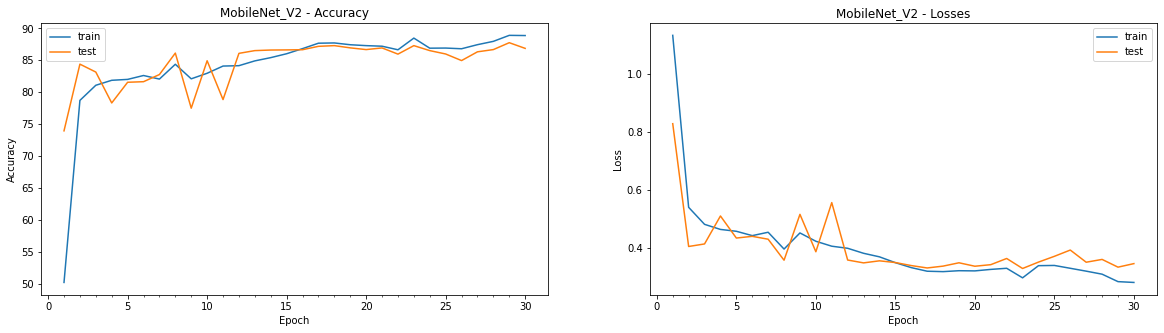

In [41]:
# Accurracy and loss history plot
m_history.plot_history(title=model_name, save_filename=f'{PLOT_DIR}/model_history.jpg')

In [42]:
import time
torch.save(model, f'{SAVED_MODELS_DIR}/s2_v1_new_model_ep30_ts{time.time()}.pt')
#torch.save(model, f'{SAVED_MODELS_DIR}/s2_model_epoch10.pt')

# Visualize few misclassified images

Ploting misclassified images:

Abbrevation used: 
T: Target, P: Prediction
FB: Flying Birds
LQC: Large QuadCopters
SQC: Small QuadCopters
WD: Winged Drones


Misclassification for Flying Birds..
Misclassification for Large QuadCopters..
Misclassification for Small QuadCopters..
Misclassification for Winged Drones..
CPU times: user 2.25 s, sys: 1.38 s, total: 3.63 s
Wall time: 1min 38s


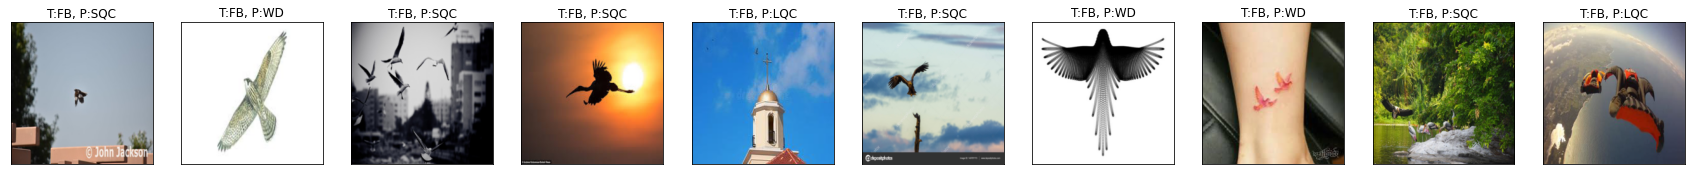

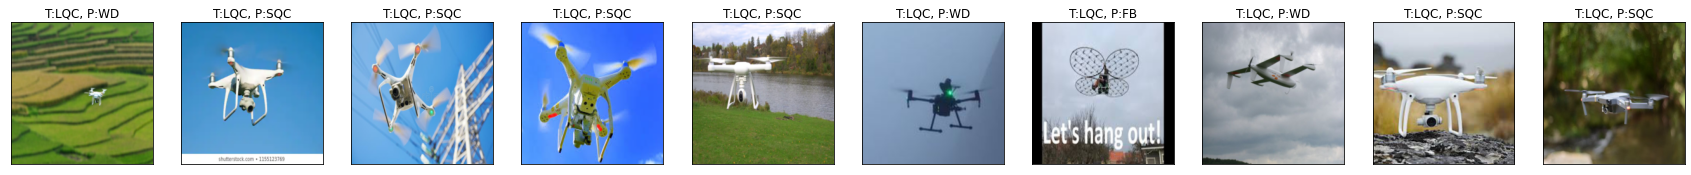

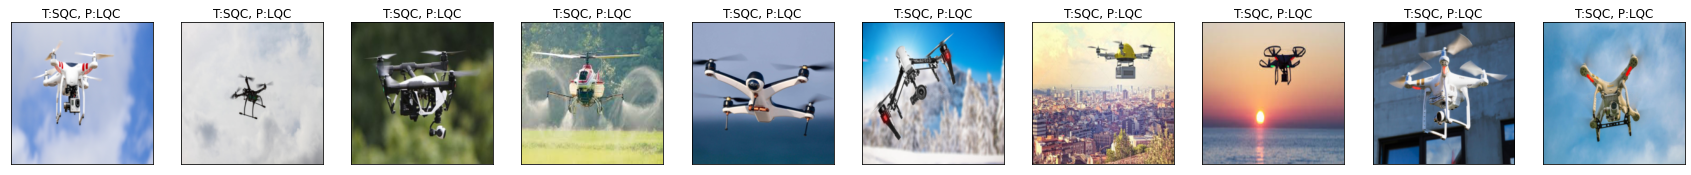

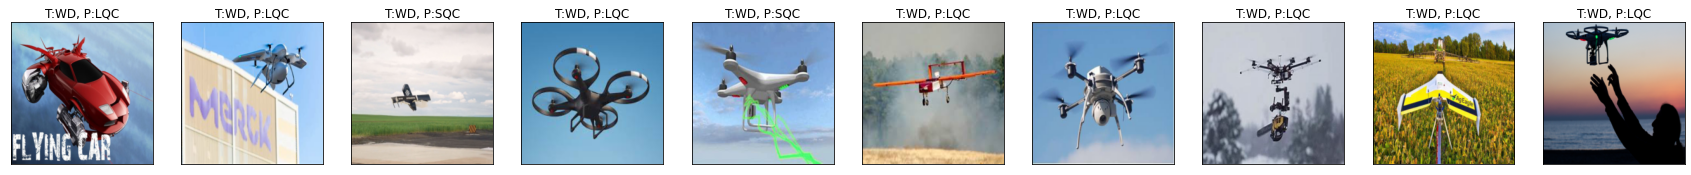

In [43]:
%%time
print('Ploting misclassified images:\n')

print('Abbrevation used: \nT: Target, P: Prediction')
display_classnames(class_list_shortname, class_list)
print('\n')
for idx, name in enumerate(class_list):
  print(f'Misclassification for {name}..')
  putils.plot_misclassified_images_for_class(model, 
                                             testloader=test_loader, 
                                              classid=idx,
                                              figsize=(30,3),
                                              num_of_images=10, nrow=1, 
                                              save_filename=f'{PLOT_DIR}/{name}_misclassified_images.jpg')